In [11]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from transformers import CLIPProcessor, CLIPModel
from tqdm.auto import tqdm
# from PIL import Image
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
import joblib

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
# Load model and pre-processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [9]:
TRAIN_IMG_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "train_set", "train_set", "images")
TRAIN_LABELS_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "train_set", "train_set", "annotations")
VAL_IMG_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "val_set", "val_set", "images")
VAL_LABELS_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "val_set", "val_set", "annotations")

In [8]:
# os.listdir(TRAIN_LABELS_PATH)

In [77]:
class CustomAffectNetDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        # store the image files in sorted order
        self.img_dir = img_dir
        self.label_dir = annotations_dir
        self.img_files = sorted(os.listdir(img_dir))
        # self.img_label_files = sorted([file for file in os.listdir(annotations_dir) if 'exp' in file])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = read_image(img_path)
        label_path = os.path.join(self.label_dir, f"{self.img_files[idx].split('.')[0]}_exp.npy")
        label = int(np.load(label_path))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [122]:
training_data = CustomAffectNetDataset(TRAIN_LABELS_PATH, TRAIN_IMG_PATH)

In [127]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [128]:
# import gc; gc.collect()

In [129]:
zs_preds = []
embeddings = torch.Tensor([])
labels = []
deepface_labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
for img, label in tqdm(train_dataloader):
    # Ignore contempt since deepface ignores it
    label_to_ignore = 7
    relevance_mask = label != label_to_ignore
    img = img[relevance_mask]
    label = label[relevance_mask]
    pil_images = [to_pil_image(i) for i in img]
    label = label.to(device)
    inputs = processor(text=["Neutral", "Happy", "Sad", "Surprise", "Fear", "Disgust", "Anger"], images=pil_images, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    emotion_pred = logits_per_image.argmax(dim=1) # we can take the argmax
    zs_preds += emotion_pred.tolist()
    labels += label.tolist()
    embeddings = torch.cat((embeddings, outputs.image_embeds.detach().cpu()))

  0%|          | 0/17979 [00:00<?, ?it/s]

In [132]:
with open("tmp_train_zs_preds.npy", "wb") as f:
    np.save(f, np.array(zs_preds))
with open("tmp_train_labels.npy", "wb") as f:
    np.save(f, np.array(labels))
with open("tmp_train_embeddings.npy", "wb") as f:
    np.save(f, np.array(embeddings))

torch.Size([283901, 512])

In [23]:
# img_files[:15]

['0.jpg',
 '1.jpg',
 '10.jpg',
 '100.jpg',
 '100000.jpg',
 '100001.jpg',
 '100002.jpg',
 '100004.jpg',
 '100006.jpg',
 '100008.jpg',
 '100009.jpg',
 '100011.jpg',
 '100012.jpg',
 '100013.jpg',
 '100015.jpg']

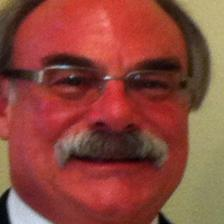

In [71]:
# Image.open(os.path.join(TRAIN_IMG_PATH, img_files[0]))

In [25]:
# label_files = sorted([file for file in os.listdir(TRAIN_LABELS_PATH) if 'exp' in file])

In [27]:
# label_files[:15]

['0_exp.npy',
 '100000_exp.npy',
 '100001_exp.npy',
 '100002_exp.npy',
 '100004_exp.npy',
 '100006_exp.npy',
 '100008_exp.npy',
 '100009_exp.npy',
 '100011_exp.npy',
 '100012_exp.npy',
 '100013_exp.npy',
 '100015_exp.npy',
 '100017_exp.npy',
 '100018_exp.npy',
 '100019_exp.npy']

In [3]:
embeddings = np.load("tmp_train_embeddings.npy")
labels = np.load("tmp_train_labels.npy")
zs_preds = np.load("tmp_train_zs_preds.npy")

In [4]:
lr_clf_emotion = LogisticRegression(random_state=42, max_iter=400)
lr_clf_emotion.fit(embeddings, labels)

LogisticRegression(max_iter=400, random_state=42)

In [5]:
y_preds = lr_clf_emotion.predict(embeddings)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(labels, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(labels, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(labels, y_preds, average='micro')
train_acc = lr_clf_emotion.score(embeddings, labels)
print(f"Training set metrics - Emotion (LR + CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Training set metrics - Emotion (LR + CLIP) 
Accuracy: 0.7628 Precision: 0.7570, Recall: 0.7628, F-Score(Weighted): 0.7529, F-Score(Micro): 0.7628, F-Score(Macro): 0.5464


In [6]:
y_preds = zs_preds
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(labels, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(labels, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(labels, y_preds, average='micro')
train_acc = np.sum(y_preds == np.array(labels)) / len(y_preds)
print(f"Training set metrics - Emotion (ZS CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Training set metrics - Emotion (ZS CLIP) 
Accuracy: 0.4440 Precision: 0.5904, Recall: 0.4440, F-Score(Weighted): 0.4948, F-Score(Micro): 0.4440, F-Score(Macro): 0.2821


In [150]:
validation_data = CustomAffectNetDataset(VAL_LABELS_PATH, VAL_IMG_PATH)

In [151]:
val_dataloader = DataLoader(validation_data, batch_size=16, shuffle=True)

In [152]:
zs_preds = []
embeddings = torch.Tensor([])
labels = []
deepface_labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
for img, label in tqdm(val_dataloader):
    # Ignore contempt since deepface ignores it
    label_to_ignore = 7
    relevance_mask = label != label_to_ignore
    img = img[relevance_mask]
    label = label[relevance_mask]
    pil_images = [to_pil_image(i) for i in img]
    label = label.to(device)
    inputs = processor(text=["Neutral", "Happy", "Sad", "Surprise", "Fear", "Disgust", "Anger"], images=pil_images, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    emotion_pred = logits_per_image.argmax(dim=1) # we can take the argmax
    zs_preds += emotion_pred.tolist()
    labels += label.tolist()
    embeddings = torch.cat((embeddings, outputs.image_embeds.detach().cpu()))

  0%|          | 0/250 [00:00<?, ?it/s]

In [153]:
with open("tmp_val_zs_preds.npy", "wb") as f:
    np.save(f, np.array(zs_preds))
with open("tmp_val_labels.npy", "wb") as f:
    np.save(f, np.array(labels))
with open("tmp_val_embeddings.npy", "wb") as f:
    np.save(f, np.array(embeddings))

In [7]:
embeddings = np.load("tmp_val_embeddings.npy")
labels = np.load("tmp_val_labels.npy")
zs_preds = np.load("tmp_val_zs_preds.npy")

In [8]:
y_preds = lr_clf_emotion.predict(embeddings)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(labels, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(labels, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(labels, y_preds, average='micro')
train_acc = lr_clf_emotion.score(embeddings, labels)
print(f"Validation set metrics - Emotion (LR + CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Emotion (LR + CLIP) 
Accuracy: 0.4869 Precision: 0.5881, Recall: 0.4869, F-Score(Weighted): 0.4548, F-Score(Micro): 0.4869, F-Score(Macro): 0.4548


In [9]:
y_preds = zs_preds
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(labels, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(labels, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(labels, y_preds, average='micro')
train_acc = np.sum(y_preds == np.array(labels)) / len(y_preds)
print(f"Validation set metrics - Emotion (ZS CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Emotion (ZS CLIP) 
Accuracy: 0.3477 Precision: 0.3928, Recall: 0.3477, F-Score(Weighted): 0.3363, F-Score(Micro): 0.3477, F-Score(Macro): 0.3363


In [12]:
# Save Emotion model
joblib.dump(lr_clf_emotion, '../models/lr_clf_emotion.joblib')
print("Model saved successfully!")
# To load the model from the file later
clf_emotion_loaded = joblib.load('../models/lr_clf_emotion.joblib')
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


In [13]:
lr_clf_emotion

LogisticRegression(max_iter=400, random_state=42)